Date: 01-11-2020  
Author: Oskar Högberg
# Illustration of all the processing taking place

In [1]:
import igraph
import numpy as np
import matplotlib.pyplot as plt
import graph_functions

## Create a graph with the raw data

In [2]:
N = 3_000
m = 2

# g = igraph.Graph.Barabasi(N,m)
g = igraph.Graph.Erdos_Renyi(N, p=2*2/N)
g = max(g.decompose(), key=igraph.Graph.vcount)

In [3]:
d_np = np.array(g.degree())
c_np = np.array(g.closeness())

In [4]:
%matplotlib inline
# %matplotlib qt5

# plt.style.use('ggplot')
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times New Roman"]})

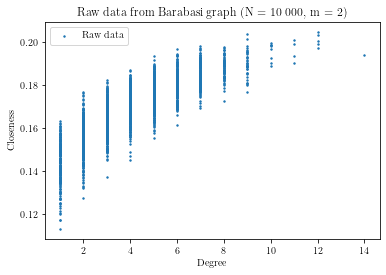

In [5]:
plt.scatter(d_np, c_np, s=2, label='Raw data')
plt.title("Raw data from Barabasi graph (N = 10 000, m = 2)")
plt.xlabel('Degree')
plt.ylabel('Closeness')
plt.legend()
plt.show()

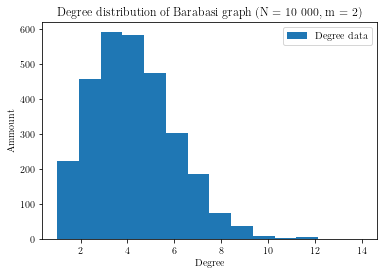

In [6]:
plt.hist(d_np, bins = max(d_np), label="Degree data")
# plt.yscale('log')
plt.title("Degree distribution of Barabasi graph (N = 10 000, m = 2)")
plt.xlabel('Degree')
plt.ylabel('Ammount')
plt.legend()
plt.show()

## Take the inverse of the closeness and the log of the degree

In [7]:
d_log = np.log(d_np)
c_inv = 1 / c_np

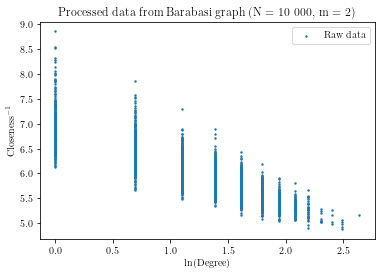

In [8]:
plt.scatter(d_log, c_inv, s=2, label='Raw data')
plt.title("Processed data from Barabasi graph (N = 10 000, m = 2)")
plt.xlabel('ln(Degree)')
plt.ylabel('Closeness$^{-1}$')
plt.legend()
plt.show()

## Create bins

In [9]:
x,y,sdx,sdy = graph_functions.closeness_and_degree_to_x_y_bins(c_np, d_np)

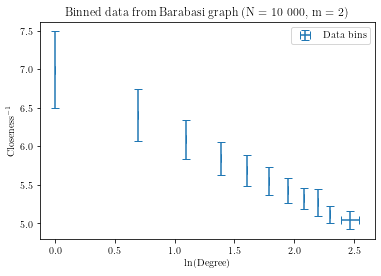

In [10]:
plt.errorbar(x,y,xerr=sdx,yerr=sdy, linestyle='None',capsize=4, label='Data bins')
plt.title("Binned data from Barabasi graph (N = 10 000, m = 2)")
plt.xlabel('ln(Degree)')
plt.ylabel('Closeness$^{-1}$')
plt.legend()
plt.show()

## Model fitting - ODR

In [11]:
from scipy.odr import ODR, Model, Data, RealData

In [12]:
# b[0] * x ** 0 + b[1] * x ** 1 + b[2] * x ** 2 + ...
def polynomial (beta, x):
    return sum([b * x ** i for i,b in enumerate(beta)])

In [13]:
model = Model(polynomial)

In [14]:
# data = Data(d, c)
binned_real_data = RealData(x=x,y=y,sx=sdx,sy=sdy)
binned_data = Data(x,y)

In [15]:
raw_real_data = RealData(d_log,c_inv)
raw_data = Data(d_log,c_inv)

In [16]:
odr_binned_real_data = ODR(binned_real_data, model, [0,0])
odr_binned_data = ODR(binned_data, model, [0,0])
odr_binned_real_data.set_job(fit_type=0)
odr_binned_data.set_job(fit_type=0)
output_real = odr_binned_real_data.run()
output_data = odr_binned_data.run()

In [17]:
odr_raw_real_data = ODR(raw_real_data, model, [0,0])
odr_raw_data = ODR(raw_data, model, [0,0])
odr_raw_real_data.set_job(fit_type=2)
odr_raw_data.set_job(fit_type=2)
raw_output_real = odr_raw_real_data.run()
raw_output_data = odr_raw_data.run()

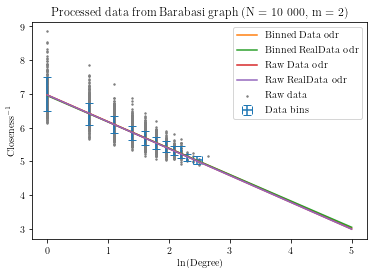

In [18]:
x_lin = np.linspace(0, 5, 10)

plt.scatter(d_log, c_inv, s=2, label='Raw data', c='tab:grey')
plt.errorbar(x,y,xerr=sdx,yerr=sdy, linestyle='None',capsize=4, label='Data bins')

plt.plot(x_lin, polynomial(output_data.beta,x_lin), label='Binned Data odr')
plt.plot(x_lin, polynomial(output_real.beta,x_lin), label='Binned RealData odr')
plt.plot(x_lin, polynomial(raw_output_data.beta,x_lin), label='Raw Data odr')
plt.plot(x_lin, polynomial(raw_output_real.beta,x_lin), label='Raw RealData odr')

plt.title("Processed data from Barabasi graph (N = 10 000, m = 2)")
plt.xlabel('ln(Degree)')
plt.ylabel('Closeness$^{-1}$')
plt.legend()
plt.show()

The difference between RealData and just Data is that one take in the standard error and the other doesn't. If the error is left out of the arguments the fit returned is the same. When fitting the curve to all the data we get a line which is more biased towards the degrees with many closeness values.

# Goodness of fit

## Chi-squared
$$\chi^{2}\left(\theta_{j} ; y_{i}\right)=\sum_{i=1}^{N}\left[\frac{y_{i}-f\left(x_{i} ; \theta_{j}\right)}{\sigma_{i}}\right]^{2}$$

In [19]:
import scipy.stats as stats

In [32]:
chi = stats.chisquare(f_obs=c_inv, f_exp=polynomial(output_data.beta, d_log), ddof=2) 
chi_bin = stats.chisquare(f_obs=y, f_exp=polynomial(output_data.beta, x), ddof=2) 

In [34]:
chi[0]/N, chi_bin[0]/N, 

(0.011123044371462033, 3.1336572978689517e-07)

In [22]:
d_sorted = sorted(list(zip(d_log, c_inv)))

# Own calculation of chi^2
X2_binned = sum(((y - polynomial(output_real.beta, x))/sdy)**2) / (len(x) - 0)

X2_raw = sum(((c_inv - polynomial(raw_output_data.beta, d_log)))**2) / len(d_log)

# Chi squared using the standard deviation of the closeness value for that degree as the error
X2_raw_sdy = sum(((c_inv - polynomial(raw_output_data.beta, d_log)))**2 / polynomial(raw_output_data.beta, d_log)) / len(d_log)

# Chi squared using the Expected closeness error (Pearson!)
X2_raw_pears = sum(((c_inv - polynomial(raw_output_data.beta, d_log)))**2) / len(d_log)

X2_raw_bin_odr = sum(((c_inv - polynomial(output_real.beta, d_log)))**2) / len(d_log)

In [23]:
bin_dict = {}
current = []
last_d = 0
for d,c in d_sorted:
    if d > last_d:
        bin_dict[last_d] = current
        current = []
        last_d = d
    else:
        current.append(c)


In [24]:
statistic = 0
statistic_pears = 0
statistic_stat = 0
for d,c in bin_dict.items():
    if len(c) > 4:
        xx = sum( ((c - polynomial(raw_output_data.beta, d)) / np.std(c)) ** 2)
        statistic += xx
        if xx > 2*len(c):
            print('large', xx, len(c), np.std(c), c, polynomial(raw_output_data.beta, d))
    else:
        # Resort to pearson when there is only one point
        statistic += sum( ((c - polynomial(raw_output_data.beta, d))) ** 2 / polynomial(raw_output_data.beta, d))

    statistic_pears += sum( ((c - polynomial(raw_output_data.beta, d))) ** 2 / polynomial(raw_output_data.beta, d))
    statistic_stat += stats.chisquare(c, f_exp=polynomial(raw_output_data.beta, d))[0]



In [25]:
statistic, statistic_stat, statistic_pears

(2942.5912446644115, 33.001828443147616, 33.00182844314762)

In [26]:
print(f'X^2 for binned data - {X2_binned}')
print(f'X^2 for raw data - {X2_raw}')
print(f'X^2 explicit binning - {statistic/len(d_log)}')
print(f'X^2 for raw data sdy - {X2_raw_sdy}')
print(f'X^2 for raw data pears - {X2_raw_pears}')
print(f'X^2 for raw data with bin odr - {X2_raw_bin_odr}')


X^2 for binned data - 0.01833542448178194
X^2 for raw data - 0.07064344634374187
X^2 explicit binning - 0.9985039852950158
X^2 for raw data sdy - 0.011321831334610283
X^2 for raw data pears - 0.07064344634374187
X^2 for raw data with bin odr - 0.07070692706393357


Using my own X^2 function we get a fit of 1.1 for the curve which looks like it fits, 1.19 for the one which is slightly different and 225 for the whack one. Did fit to the binned one tho... 

Changing the fit type to 2 makes the fit look better for the whack one but gives a X^2 of 1772 instead. The fit which was good before is increased to 3.6.

Uhmmm i cant replicate this... I get higher values in the 3-7 range now

Divided the $X^2$ by the number of data points which supposedly gives us the $X_{dof}$. This is apparently what we want? It gives us quite nice results really since the X^2 is a lot less than 1, ~0.2 for both.

## What can we do with the raw data?
Can we get some sort of probability distribution which we can do analysis on????

### Take difference between all the values and the predicted line:
- Calculate the residuals by taking the difference between closeness and the fitted closeness for every degree point.
    - Use the regression which is fitted to that specific data set. i.e. raw or binned
- Take the absolute values since the distance is always positive
- plot as a histogram

In [39]:
residuals = list(map(
    lambda point: (point[1] - polynomial(raw_output_real.beta, point[0])),
    zip(d_log, c_inv)))
mean, gaussian_std = stats.norm.fit(residuals)

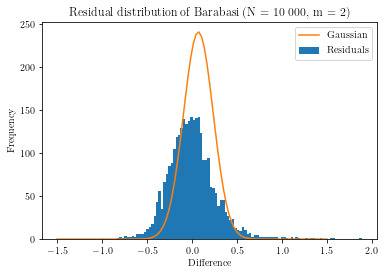

In [42]:
plt.hist(residuals, bins=100, label="Residuals")

x_gaussian = np.linspace(-1.5, 1.5, 100)
plt.plot(x_gaussian, 100*stats.norm.pdf(x_gaussian, mean, gaussian_std), label='Gaussian')

plt.title("Residual distribution of Barabasi (N = 10 000, m = 2)")
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [43]:
print("mean : ", mean, '\nstd  : ', std, '\nvariance : ', std**2)

NameError: name 'std' is not defined

In [44]:
residuals = list(map(
    lambda point: abs(point[1] - polynomial(raw_output_real.beta, point[0])),
    zip(d_log, c_inv)))
residuals = np.array(residuals)
residuals_for_gauss = []
for r in residuals:
    residuals_for_gauss.append(r)
    residuals_for_gauss.append(-r)
mean, gaussian_std = stats.norm.fit(residuals_for_gauss)

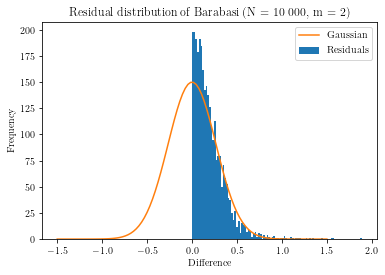

In [52]:
plt.hist(residuals, bins=100, label="Residuals")

x_gaussian = np.linspace(-1.5, 1.5, 100)
plt.plot(x_gaussian, 100*stats.norm.pdf(x_gaussian, mean, gaussian_std), label='Gaussian')

plt.title("Residual distribution of Barabasi (N = 10 000, m = 2)")
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.legend()
plt.show()

We can see that the distribution is relatively gaussian about the origin!  
This justifies the use of the likelihood with a gaussian distribution. 

## Likelihood$^*$
$$L\left(\theta ; x_{i}\right)=\prod_{i=1}^{N} P\left(x_{i} ; \theta\right)$$

For a given value of (d,c) the probability of measuring c is distributed as a gaussian about the value of the regression at that degree value.

In [212]:
def gaussian(x, mean, std):
    return 1.0/(std * np.sqrt(2*np.pi)) * np.exp( -1/2 * ( ( (x - mean)/std ) ** 2) )

In [213]:
def likelihood_gauss_regression(f, beta, gaussian_std, x, y):
    product = 1
    for x_i, y_i in zip(x,y):
        P = gaussian(y_i, polynomial(raw_output_real.beta, x_i), gaussian_std)
        # print(product)
        product *= P
    return product

In [214]:
def log_likelihood_gauss_regression(f, beta, gaussian_std, x, y):
    return sum([np.log(gaussian(y_i, polynomial(beta, x_i), gaussian_std)) for x_i, y_i in zip(x,y)])

In [215]:
gaussian(c_inv[1000], polynomial(raw_output_real.beta, d_log[1000]), gaussian_std)

0.013028002792122746

In [216]:
likelihood_gauss_regression(polynomial, raw_output_real.beta, gaussian_std, d_log, c_inv)

0.0

likelihood_gauss_regression returns 0 becuase the number gets so small. Need to do log likelihodd instead

In [217]:
raw_log_L = log_likelihood_gauss_regression(polynomial, raw_output_data.beta, gaussian_std, d_log, c_inv)

log likelihood seems to suggest the best fit is the "output data". Which agrees with chi-squared method

# BIC Calculations

The BIC is defined as
$$
\mathrm{BIC}=k \ln (n)-2 \ln (\widehat{L})
$$
k is number of parameters  
L is maximum likelihood  
n is the number of data points in x

In [218]:
def bic_value(k, n, log_L_max):
    return k * np.log(n) - 2 * log_L_max

In [219]:
bic_value(3, len(d_log), output_data_log_L)

12195.67975936052